In [16]:
import pandas as pd 
from ms2rescore import plotting
from ms2rescore.percolator import PercolatorIn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import re
import pickle
from matplotlib_venn import venn2
from collections import defaultdict
from immuno_ms2rescore_tools import file_utilities


In [17]:
sns.set_context("notebook")

In [18]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# Count spectra

In [19]:

mgf_files = file_utilities.MascotGenericFormat("/home/arthur/ms2rescore-immunopeptidomics-manuscript/notebooks/data/PXD015408/mgf")
spectra_count = mgf_files.count_spectra()

100%|██████████| 9/9 [00:01<00:00,  6.49it/s]


In [20]:
spectra_count

,raw file,spectra
0,Unanue_7733_180712_05,14626
1,ERU_7772_NOD_180916_07,16067
2,Unanue_7681_180316_04,24899
3,Unanue_7707_180517_03,14689
4,Unanue_7715_180601_08,12336
5,Unanue_7683_180322_03,21480
6,Unanue_7872_190321_06,33901
7,Unanue_7873_190321_10,42104
8,Unanue_7797_181026_04,18567
9,total,198669


# HLA-II peaks analysis

In [21]:
path_pxd015408 = "data/PXD015408/"
plotting.RescoreRecord.empty_rerecs()
pin = plotting.PIN(path_pxd015408+"peptides_1_1_0_searchengine_ms2pip_rt_features.pin", sample_name="HLA-II", score_metric="PEAKS:peptideScore")
searchengine = plotting.POUT(path_pxd015408+"peptides_1_1_0_searchengine_features.pout",path_pxd015408+"peptides_1_1_0_searchengine_features.pout_dec", rescoring_features="Search engine", sample_name="HLA-II")
ms2rescore = plotting.POUT(path_pxd015408+"peptides_1_1_0_searchengine_ms2pip_rt_features.pout",path_pxd015408+"peptides_1_1_0_searchengine_ms2pip_rt_features.pout_dec", rescoring_features="MS²Rescore", sample_name="HLA-II")


In [22]:
accepted_targets = list(ms2rescore.df["PSMId"][(ms2rescore.df["q"] < 0.01)])
len(accepted_targets)

9388

In [23]:
HLA_II_length = pd.DataFrame()
HLA_II_length["PSMId"] = ms2rescore.df.PSMId
HLA_II_length["length"] = ms2rescore.df["peptide"].apply(len)
HLA_II_length["Label"] = ["decoy" if  x else "target" for x in ms2rescore.df["is decoy"]]
HLA_II_length.loc[(HLA_II_length.PSMId.isin(accepted_targets)) & (HLA_II_length["Label"] == "target"), "Label"] = "accepted target"
HLA_II_length.reset_index(drop=True, inplace=True)


<AxesSubplot:xlabel='length', ylabel='Density'>

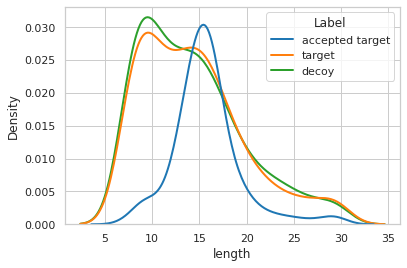

In [24]:
sns.kdeplot(
    x="length",
    data=HLA_II_length,
    hue="Label",
    common_norm=True, 
    linewidth=2, 
    bw_adjust=2,
)

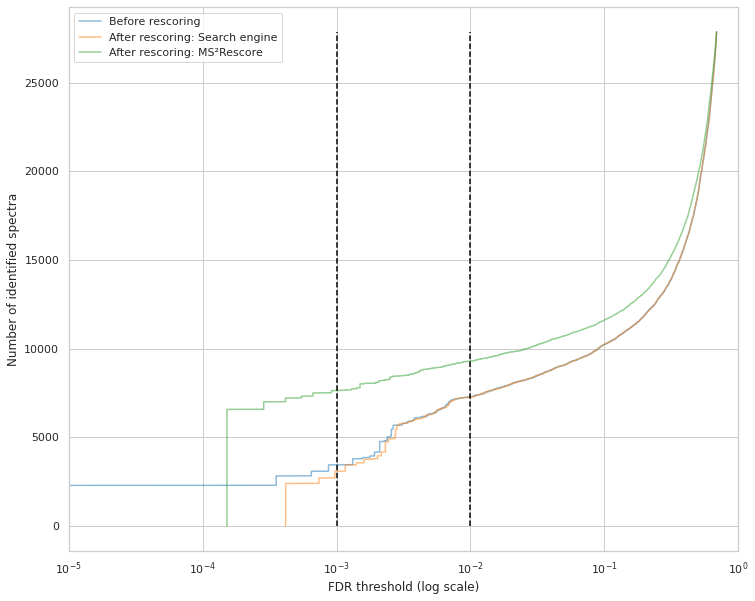

In [25]:
sns.set_style(style="whitegrid")
ax = plotting.RescoreRecord.qvalue_comparison()
#ax.set_ylim(0,1000)
#ax.vlines([0.01, 0.001],ymin=0,ymax=1000, colors="black", linestyles="dashed")
plt.show()

In [26]:
plotting.RescoreRecord._count_identifications([0.001, 0.01])
plotting.RescoreRecord._separate_unique_peptides(FDR_threshold=[0.001, 0.01])
plotting.RescoreRecord.calculate_loss_gain_df(FDR_threshold=[0.001,0.01], reference="After rescoring: Search engine")

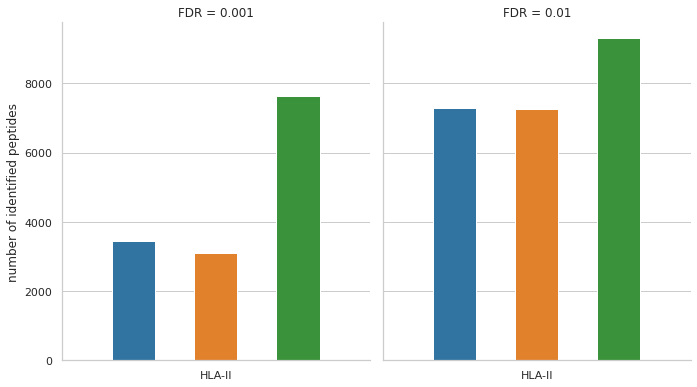

In [27]:
sns.set_style("whitegrid")
g = plotting.RescoreRecord.count_plot()
for ax in g.axes[0]:
    change_width(ax, 0.14)
g.fig.set_size_inches(13, 6)
g._legend.remove()
#plt.legend(title='',bbox_to_anchor=(-0.53,1))
plt.show()

In [28]:
plotting.RescoreRecord.count_df["count"] = (plotting.RescoreRecord.count_df["count"]/198669) * 100

In [ ]:
sns.set_context("notebook", font_scale=1.3)
fig = plt.Figure(figsize=(15,5))

ax1 = plt.subplot2grid((2,3),(0,0), colspan=1, fig=fig)
sns.barplot(
    x="count",
    y="rescoring",
    data=plotting.RescoreRecord.count_df[plotting.RescoreRecord.count_df["FDR"]== 0.01],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax1
)
ax1.set_ylabel("1% FDR")
ax1.yaxis.labelpad = 25
ax1.set_xlabel("")
ax1.set_title("A",loc="left")

ax2 = plt.subplot2grid((2,3),(0,1), colspan=1, fig=fig)
sns.barplot(
    x="count",
    y="rescoring",
    data=plotting.RescoreRecord.unique_df[plotting.RescoreRecord.unique_df["FDR"]== 0.01],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax2
)
ax2.set_ylabel("")
ax2.set_yticklabels([])
ax2.set_xlabel("")

ax2.set_title("C",loc="left")

ax3 = plt.subplot2grid((2,3),(0,2),colspan=1, fig=fig)
sns.barplot(
    y="feature",
    x="gain",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.01],
    palette=sns.color_palette(["#2FA92D","#2FA92D","#2FA92D","#B3EBB2"]),
    ax=ax3,
    label="gain"
)
sns.barplot(
    y="feature",
    x="shared",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.01],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax3,
    label="shared"
)
sns.barplot(
    y="feature",
    x="loss",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.01],
    palette=sns.color_palette(["#FF0000","#FF0000","#FF0000","#FFABAB"]),
    ax=ax3,
    label="loss"
)
ax3.set_xlim(-10,210)
ax3.set_ylabel("")
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(
    [handles[idx] for idx in [2,1,0]],
    [labels[idx] for idx in [2,1,0]],
    frameon=False, 
    ncol=3, 
    bbox_to_anchor=(1.0,1.41),
    handletextpad=0.5, 
    handlelength=0.85, 
    columnspacing=0.5
)
ax3.set_xlabel("")
ax3.set_yticklabels([])
ax3.set_title("E",loc="left")



ax4 = plt.subplot2grid((2,3),(1,0),colspan=1, fig=fig, sharex=ax1)
sns.barplot(
    x="count",
    y="rescoring",
    data=plotting.RescoreRecord.count_df[plotting.RescoreRecord.count_df["FDR"]== 0.001],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax4
)
ax4.set_ylabel("0.1% FDR")
ax4.yaxis.labelpad = 25
ax4.set_xlabel("spectrum identification rate (%)")
ax4.xaxis.labelpad = 15
ax4.set_title("B",loc="left")

ax5 = plt.subplot2grid((2,3),(1,1),colspan=1, fig=fig, sharex=ax2)
sns.barplot(
    x="count",
    y="rescoring",
    data=plotting.RescoreRecord.unique_df[plotting.RescoreRecord.unique_df["FDR"]== 0.001],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax5
)
ax5.set_ylabel("")
ax5.set_yticklabels([])
ax5.set_xlabel("unique peptides")
ax5.xaxis.labelpad = 15
ax5.set_title("D",loc="left")

ax6 = plt.subplot2grid((2,3),(1,2),colspan=1, fig=fig, sharex=ax3)
sns.barplot(
    y="feature",
    x="gain",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.001],
    palette=sns.color_palette(["#2FA92D","#2FA92D","#2FA92D","#B3EBB2"]),
    ax=ax6,
)
sns.barplot(
    y="feature",
    x="shared",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.001],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax6,
)
sns.barplot(
    y="feature",
    x="loss",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.001],
    palette=sns.color_palette(["#FF0000","#FF0000","#FF0000","#FFABAB"]),
    ax=ax6,
)
ax6.set_ylabel("")
ax6.set_xlabel("identfication overlap (%)")
ax6.xaxis.labelpad = 15
ax6.set_yticklabels([])
ax6.set_title("F",loc="left")
fig.tight_layout(rect=[0, 0, 1, 1])
fig.savefig("data/Figures/FigureS7.svg")


In [ ]:
plotting.RescoreRecord.loss_gain_df

,sample,feature,FDR,shared,gain,loss
0,HLA-II,Before rescoring,0.001,100.000000,108.768116,-0.000000
1,HLA-II,After rescoring: Search engine,0.001,100.000000,100.000000,-0.000000
2,HLA-II,After rescoring: MS²Rescore,0.001,99.927536,201.086957,-0.072464
3,HLA-II,Before rescoring,0.010,99.928648,100.249732,-0.071352
4,HLA-II,After rescoring: Search engine,0.010,100.000000,100.000000,-0.000000
5,HLA-II,After rescoring: MS²Rescore,0.010,96.824831,116.232608,-3.175169


# Weight analysis

In [ ]:
def calculate_feature_weights(weights_file):
    feature_weights = {}

    weights = pd.read_table(weights_file, sep="\t")
    weights.drop([1,2,4,5,7], axis=0, inplace=True)
    weights.drop("m0", axis=1, inplace=True)
    weights = weights.astype(float)
    weights.loc["mean"] = weights.mean()

    total_weight = sum(weights.iloc[3, :71].abs()) + sum(weights.iloc[3, 71:77].abs()) + sum(weights.iloc[3, 77:].abs())
    feature_weights["MS²PIP"] = (sum(weights.iloc[3, :71].abs())  /total_weight) * 100
    feature_weights["DeepLC"] = (sum(weights.iloc[3, 71:77].abs()) /total_weight) * 100
    feature_weights["Search engine"] = (sum(weights.iloc[3, 77:].abs()) /total_weight) * 100
    
    return feature_weights

In [ ]:
ft_weights = calculate_feature_weights("data/PXD015408/peptides_1_1_0_searchengine_ms2pip_rt_features.weights")

In [ ]:
ft_weights

{'MS²PIP': 74.35935474591741,
 'DeepLC': 15.770967908261246,
 'Search engine': 9.869677345821344}